In [1]:
import os
import random
import time
from dataclasses import dataclass
import uuid

import gym
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import wandb
import argparse
import yaml
import pickle
from policy_finetune.scripts.actor_utils import FeatureExtractor
from policy_finetune.scripts.sac_rlpd import Actor, SoftQNetwork
from policy_finetune.scripts.utils import *
from tensordict import MemoryMappedTensor, TensorDict
from gym_env.env.radar_env import RadarEnv, MapConfig
from evasion_guidance.scripts.evasion_risk import EvasionRisk
%matplotlib widget

In [2]:
checkpoints_path = "/home/yixuany/workspace/CORL/output"
run_name = "SAC_rlpd-f27b7933"
model_dict = torch.load(os.path.join(checkpoints_path, run_name, "actor_checkpoint_1790000.pt"))
q_model_dict = torch.load(os.path.join(checkpoints_path, run_name, "q1_checkpoint_1790000.pt"))

In [3]:
with open(os.path.join(checkpoints_path, run_name, "config.yaml"),"r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [4]:
# Set environment parameters.
img_size = config['env']['img_size']
time_max = config['env']['max_time_step']
observation_img_size = [3, img_size, img_size]
action_min = -1.0
action_max = 1.0
action_dim = config['env']['action_dim']
action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(action_dim,))
map_size = config['env']['map_size']
observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                    "goal_direction": gym.spaces.Box(-1, 1, shape=(2,)),
                    "current_loc": gym.spaces.Box(0, 1, shape=(2,)),
                    "time_spent": gym.spaces.Box(-1, 1, shape=(2,))})

In [5]:
model_dict

OrderedDict([('action_scale', tensor(1., device='cuda:0')),
             ('action_bias', tensor(0., device='cuda:0')),
             ('feature_extractor.extractors.heat_map.cnn.0.weight',
              tensor([[[[-9.9015e-02, -7.3870e-02, -5.2021e-02,  ...,  1.5706e-01,
                          9.5687e-02,  2.3917e-01],
                        [-2.8920e-01, -2.3399e-01, -1.3645e-01,  ...,  6.8754e-02,
                          1.0678e-01,  1.0047e-01],
                        [-4.1492e-01, -2.8497e-01, -1.7886e-01,  ..., -1.1217e-01,
                         -1.0855e-02,  1.0610e-01],
                        ...,
                        [-4.0846e-01, -2.9488e-01, -3.3536e-01,  ..., -9.0836e-02,
                         -8.5582e-02, -2.6300e-02],
                        [-4.0664e-01, -2.8084e-01, -2.3480e-01,  ..., -8.4735e-02,
                         -3.0500e-02,  9.9755e-02],
                        [-2.8757e-01, -3.5288e-01, -2.7423e-01,  ...,  2.6422e-02,
                          

In [6]:
actor = Actor(observation_space, action_dim, action_max, action_min)
actor.load_state_dict(model_dict)
actor.eval()

Actor(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (current_loc): Flatten(start_dim=1, end_dim=-1)
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fc1): Linear(in_features=262, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_mean): Linear(in_features=64, out_features=1, bias=True)
  (fc_logstd): Linear(in_features=64, out_features=

In [7]:
q_network = SoftQNetwork(observation_space, action_dim)
q_network.load_state_dict(q_model_dict)
q_network.eval()

SoftQNetwork(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (current_loc): Flatten(start_dim=1, end_dim=-1)
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fc1): Linear(in_features=263, out_features=256, bias=True)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (norm2): LayerNorm((256,), eps=1e-05,

In [8]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
time_scaling = config['env']['observation']['time_scaling']
action_rescaling = config['env']['action_max']
max_time_steps = config['env']['max_time_step']

In [9]:
episode_idx = 20

In [10]:
episode_idx = 50
data_path = "/home/yixuany/workspace/CORL/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']
# goal_location = [1000.0, -100.0]

risk_evaluator = EvasionRisk(radar_locs, radar_orientations, 0, 100)


time_spent = 0
time_spent_heat_map = 0
total_risk = 0
trajectory = [state_cur]
q_values = []
heat_map_history = None
start = time.time()
with torch.no_grad():
    while np.linalg.norm(state_cur[:2] - goal_location) > config['env']['goal_tolerance']:
        # if time_spent % 10 == 0:
        #     print("Time spent: ", time_spent)
        if time_spent > max_time_steps:
            print("Reached time limit.")
            break
        hm_start = time.time()
        
        heat_map = get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size)
        hm_end = time.time()
        time_spent_heat_map += hm_end - hm_start
        goal_direction = center_state(state_cur, goal_location) / (map_size / 2.0)
        
        if heat_map_history is None:
            heat_map_history = torch.from_numpy(heat_map).repeat(3, 1, 1).float()
        else:
            heat_map_history = torch.roll(heat_map_history, -1, dims=1)
            heat_map_history[-1, :] = torch.from_numpy(heat_map).float()

        obs = TensorDict({
            'heat_map': heat_map_history.unsqueeze(dim=0),
            'goal_direction': torch.from_numpy(goal_direction).unsqueeze(dim=0).float(),
            "current_loc": torch.from_numpy(state_cur[:2] / map_size).unsqueeze(dim=0).float(),
            "time_spent": torch.from_numpy(np.array([np.cos(time_spent / max_time_steps), np.sin(time_spent / max_time_steps)])).unsqueeze(dim=0).float()
        })

        pi, log_pi, mean = actor.get_action(obs)
        u = mean.squeeze().cpu().detach().numpy()
        # print("Control: ", u)
        u = action_rescaling*u
        q_values.append(q_network(obs, mean).squeeze().cpu())
        total_risk += risk_evaluator.evalute_risk(state_cur, u)
        state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u/V])
        time_spent += 1
        # print(state_cur)
        trajectory.append(state_cur)
end = time.time()
# print("Total time steps: ", time_spent)
print("Total Time: ", end - start)
# print("Time spent on heat map", time_spent_heat_map)
print("Length of trajectory: ", len(trajectory))
print("Total Risk: ", total_risk)
trajectory = np.asarray(trajectory)
q_values = np.asarray(q_values)

Total Time:  3.799194097518921
Length of trajectory:  126
Total Risk:  0


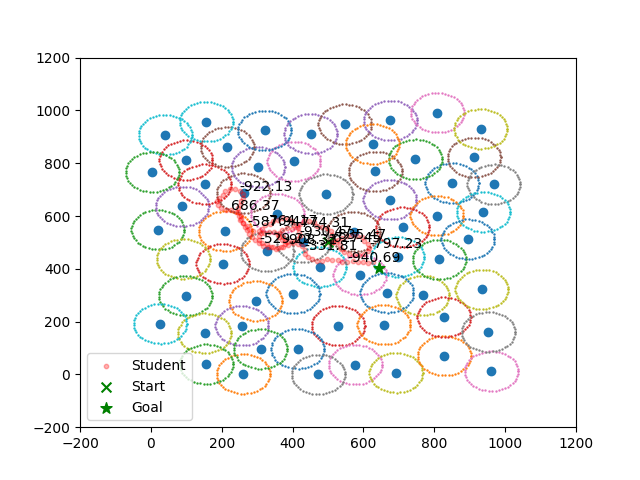

In [11]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])
ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r', alpha=0.3, label='Student')
# ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=10, c='g', alpha=0.3, label='Expert')
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')

for i, q_val in enumerate(q_values):
    if i % 10 == 0:
    # if q_val < 0:
        ax.annotate(int(100*q_val)/100, (trajectory[i, 0], trajectory[i, 1]))

ax.set_xlim(-200, 1.2*map_size)
ax.set_ylim(-200, 1.2*map_size)
ax.legend()
plt.show()